In [1]:
from PIL import Image
import numpy as np
import os

In [2]:
DIRNAME = 'smileys_dataset_all/'
SIZE = 32
files = os.listdir(DIRNAME)
N_data = len(files) * 2
train_data = np.zeros((N_data, SIZE, SIZE, 3))
for i,file in enumerate(files):
    im = Image.open(DIRNAME + file).convert('RGB').resize((SIZE, SIZE))
    train_data[i] = np.array(im).astype(np.float32)
    train_data[i+len(files)] = train_data[i][:,::-1,:]

C:\Users\suzuk\Anaconda3\lib\site-packages\PIL\Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

C:\Users\suzuk\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
N_noise = 100
def generator_model():
    model = Sequential()
    model.add(Dense(1024, input_dim = N_noise))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128 * 8 * 8))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((128, 8, 8)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, kernel_size = 5, strides = 1, padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, kernel_size = 5, strides = 1, padding = 'same'))
    model.add(Activation('tanh'))
    return model

In [9]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', input_shape = (3, 32, 32)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size = 5, strides = 2))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [45]:
BATCH_SIZE = 16
NUM_EPOCH = 100
GENERATED_IMAGE_PATH = 'generated_images/'
if not os.path.exists(GENERATED_IMAGE_PATH):
    os.mkdir(GENERATED_IMAGE_PATH)

def train():
    X_train = (train_data - 127.5) / 127.5
    X_train = X_train.reshape(N_data, 3, SIZE, SIZE)
    discriminator = discriminator_model()
    opt_d = Adam(lr = 1e-5, beta_1 = 0.1)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt_d)
    
    discriminator.trainable = False
    generator = generator_model()
    dcgan = Sequential([generator, discriminator])
    opt_g = Adam(lr = 2e-5, beta_1 = 0.5)    
    dcgan.compile(loss='binary_crossentropy', optimizer=opt_g)
    
    num_batches = int(N_data / BATCH_SIZE)
    for epoch in range(NUM_EPOCH):
        
        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, N_noise) for _ in range(BATCH_SIZE)])
            #noise = np.array([np.random.normal(0, 1/3, N_noise) for _ in range(BATCH_SIZE)])
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)
        
            if index == num_batches - 1 and epoch % 2 == 0:
                for n,image in enumerate(generated_images):
                #image = combine_images(generated_images)
                    image = image*127.5 + 127.5
                    Image.fromarray(image.astype(np.uint8).reshape(SIZE,SIZE,3)) \
                                                      .save(GENERATED_IMAGE_PATH+"%03d_%03d.png" % (epoch, n))
                
            X = np.concatenate((image_batch, generated_images))
            #y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
            y = np.concatenate((np.random.uniform(0.7,1.2,BATCH_SIZE), np.random.uniform(0, 0.3, BATCH_SIZE)))
            d_loss = discriminator.train_on_batch(X, y)
            
            noise = np.array([np.random.uniform(-1, 1, N_noise) for _ in range(BATCH_SIZE)])
            #noise = np.array([np.random.normal(0, 1/3, N_noise) for _ in range(BATCH_SIZE)])
            g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
            if index  == num_batches - 1:
                print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))
    generator.save_weights('generator.h5')
    discriminator.save_weights('discriminator.h5')

In [46]:
train()

C:\Users\suzuk\Anaconda3\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, batch: 158, g_loss: 1.056937, d_loss: 0.425368
epoch: 1, batch: 158, g_loss: 1.148352, d_loss: 0.388426
epoch: 2, batch: 158, g_loss: 1.262320, d_loss: 0.354225


KeyboardInterrupt: 

In [18]:
h = [np.random.normal(0, 0.5) for n in range(10)]

[-0.8936339064048189,
 0.10801800961855465,
 0.25020356152075746,
 0.7308961335777517,
 0.16966231905136683,
 0.23817969550281287,
 1.018971869276686,
 0.4715517252711785,
 0.20657813485395704,
 -0.26337382744674104]

In [19]:
import matplotlib.pyplot as plt

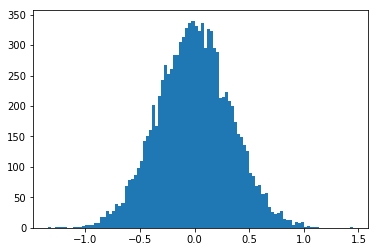

In [33]:
N_sample = 10000
h = [np.random.normal(0, 1/3) for n in range(N_sample)]
plt.hist(h,100)
plt.show()

In [35]:
np.random.normal(1,1,10)

array([ 0.37469141,  0.76746393,  0.98625509,  0.03931751,  2.46666944,
       -0.02067501, -0.48933874,  1.34850797, -0.28702744,  2.19730998])

In [38]:
np.random.uniform(0.7,1.2,10)

array([0.85055732, 1.09348412, 0.89782504, 1.15589675, 1.06322079,
       1.19019719, 0.77378017, 0.80134491, 0.82122416, 0.70697949])